# OpenCV校正
---
要先安裝 Matlab.engine [網址](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

In [1]:
%matplotlib inline
import sys
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import math

In [2]:
# 讀 csv
TotalData = []
with open("mappingData.csv", newline="\n") as csvfile:
    # 抓資料進來
    data = csv.reader(csvfile, delimiter=',')
    
    # Sum Data
    for rowData in data:
        # 把資料轉成數字
        TempData = []
        for colData in rowData:
            TempData.append(float(colData))
            
        # 不加空白的東西
        if len(TempData) > 0:
            TotalData.append([TempData])
        
    
TotalData = np.asarray(TotalData, dtype=np.float32)
print("DataSize: ", TotalData.shape)

DataSize:  (220, 1, 4)


In [3]:
# Test
TotalData[0]

array([[252. ,  77. ,   9.5,   4.5]], dtype=float32)

## 抓資料的函式
---

In [4]:
# 分別抓出資料
def GetData(TotalData):
    rows, _, cols = TotalData.shape
    objP = np.zeros([rows, cols - 2 + 1], np.float32)
    objP[:, :2] = TotalData[:, 0, 2:]
    
    imgP = TotalData[:, :, :2]
    dataSize, _, channels = imgP.shape
    imgP = imgP.reshape([dataSize, channels])
    imgP = np.array([imgP])
    objP = np.array([objP])
    print(imgP.shape, objP.shape)
    
    # objP = np.asarray(objP)
    # imgP = np.asarray([imgP])
    
    return imgP, objP

In [5]:
def GetMidIndex(objP):
    oneIndex = []
    nonOneIndex=  []
    for i in range(objP.shape[1]):
        objX, objY, _ = objP[0, i]
        
        objX = int(objX * 2)
        objY = int(objY * 2)
        if objX % 2 == 1 or objY % 2 == 1:
            oneIndex.append(i)
        else:
            nonOneIndex.append(i)
    oneIndex = np.array(oneIndex)
    nonOneIndex = np.array(nonOneIndex)
    return oneIndex, nonOneIndex

In [6]:
imgP, objP = GetData(TotalData)
indexArray, nonIndexArray = GetMidIndex(objP)
print(indexArray.shape, nonIndexArray.shape)

(1, 220, 2) (1, 220, 3)
(164,) (56,)


## 產生原圖
---

In [7]:
# 中心
def RotatePointCloud(Point, CenterIndex = 116, RotateAngle = 0):
    # 跑每一個點
    RotateP = []
    for i in range(len(Point)):
        if i != CenterIndex:  # 判斷是否要轉
            cx, cy = Point[CenterIndex] # Center
            px, py = Point[i] # 現在的點
            
            qx = cx + math.cos(RotateAngle) * (px - cx) - math.sin(RotateAngle) * (py - cy)
            qy = cy + math.sin(RotateAngle) * (px - cx) + math.cos(RotateAngle) * (py - cy)
            RotateP.append([qx, qy])
        else:
            cx, cy = Point[CenterIndex] # Center
            RotateP.append([cx, cy])
    return RotateP

In [8]:
# 旋轉一個角度
rotateP = RotatePointCloud(imgP[0], 116, -4 * math.pi / 180)
rotateP = np.array(rotateP, dtype=np.float32)

caliRotateP = rotateP[indexArray]
caliObjP = objP.reshape([-1, 3])[indexArray]
predRotateP = rotateP[nonIndexArray]
predObjP = objP.reshape([-1, 3])[nonIndexArray]

caliRotateP = caliRotateP.reshape([1, -1, 2])
predRotateP = predRotateP.reshape([1, -1, 2])

caliObjP = caliObjP.reshape([1, -1, 3])
predObjP = predObjP.reshape([1, -1, 3])

print(caliRotateP.shape, caliObjP.shape)
print(predRotateP.shape, predObjP.shape)

(1, 164, 2) (1, 164, 3)
(1, 56, 2) (1, 56, 3)


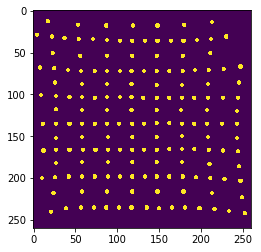

In [9]:
# 產生圖
fig = np.zeros([260, 260], np.float32)

_, size, _ = caliRotateP.shape
for i in range(size):
    px, py = caliRotateP[0, i]
    px = int(px)
    py = int(py)
    cv2.circle(fig, (px, py), 1, (255, 0, 0), 2)
# plt.imshow(fig, cmap='gray')
plt.imshow(fig)
plt.show()
# cv2.imwrite('imgs/a.png', fig)

In [10]:
# print(imgP[0, 116], objP[0, 116])

## 校正
---

In [11]:
# gray = cv2.imread("CalibrationPNG.png", cv2.IMREAD_GRAYSCALE)
h, w = fig.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(caliObjP, caliRotateP, fig.shape[::-1],None,None)
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

## 直接對應轉點
---

In [12]:
UnDistort = cv2.undistortPoints(caliRotateP, mtx, dist, None, newcameramtx)

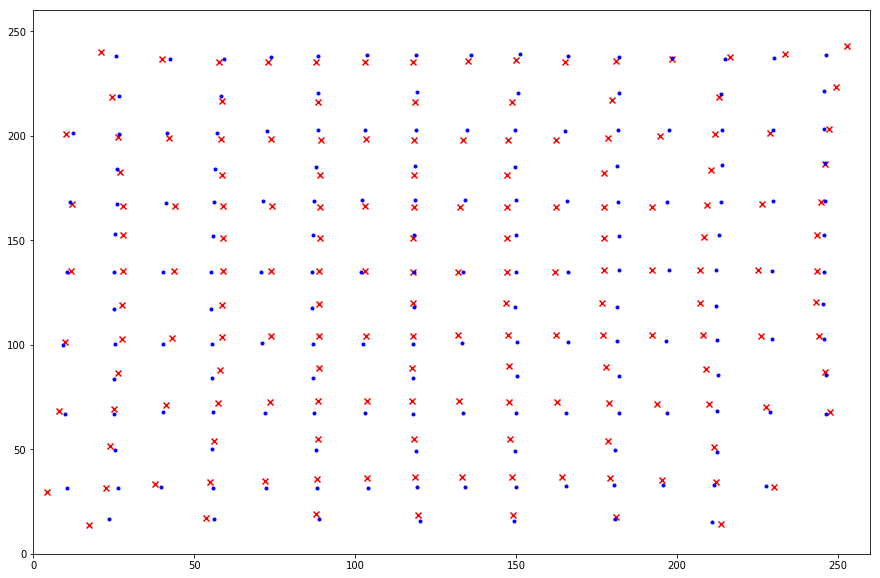

In [13]:
# plt.axis("off")
plt.figure(figsize=(15, 10))
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.scatter(caliRotateP[0, :, 0], caliRotateP[0, :, 1], c='r', marker='x')
plt.scatter(UnDistort[0,:,0], UnDistort[0,:,1], c='b', marker='.')
plt.show()

## 直接轉圖途用
---

In [14]:
# cv2.imread("")
# UnDistort = cv2.undistortPoints(rotateP, mtx, dist, None, newcameramtx)

## 輸出成檔案
---
寫出四個檔案
1. 原始 Calibration Rotate 點
2. 原始 Valid 的 Rotate 點
3. 再來 Undistort Calibration Rotate 點
4. 在 Undistort Valid 的 Rotate 點

In [15]:
# 寫 Calibration 的點
file = open("Calibration.csv", mode="w")

for i in range(caliRotateP.shape[1]):
    ux, uy = caliRotateP[0, i]
    ox, oy, _ = caliObjP[0, i]
    file.write(str(ux) + "," + str(uy) + "," + str(ox) + "," + str(oy) + "\n")
file.close()

In [16]:
# 寫 Calibration 的點
file = open("Valid_Calibration.csv", mode="w")

for i in range(predRotateP.shape[1]):
    ux, uy = predRotateP[0, i]
    ox, oy, _ = predObjP[0, i]
    file.write(str(ux) + "," + str(uy) + "," + str(ox) + "," + str(oy) + "\n")
file.close()

In [17]:
# 寫 UnDistort 的點
TotalData = []
file = open("UnDistort_Calibration.csv", mode="w")

# Distort
UnDistort_Calibration = cv2.undistortPoints(caliRotateP, mtx, dist, None, newcameramtx)
print(UnDistort_Calibration.shape)

for i in range(UnDistort_Calibration.shape[1]):
    ux, uy = UnDistort_Calibration[0, i]
    ox, oy, _ = caliObjP[0, i]
    file.write(str(ux) + "," + str(uy) + "," + str(ox) + "," + str(oy) + "\n")
file.close()

(1, 164, 2)


In [18]:
# 寫 UnDistort 的點
TotalData = []
file = open("UnDistort_Valid_Calibration.csv", mode="w")

# Distort
UnDistort_Predict = cv2.undistortPoints(predRotateP, mtx, dist, None, newcameramtx)
print(UnDistort_Predict.shape)

for i in range(UnDistort_Predict.shape[1]):
    ux, uy = UnDistort_Predict[0, i]
    ox, oy, _ = predObjP[0, i]
    file.write(str(ux) + "," + str(uy) + "," + str(ox) + "," + str(oy) + "\n")
file.close()

(1, 56, 2)


## 轉成把資料轉到 C++ 
---

In [19]:
# 寫 Calibration 的點
file = open("Calibration_C.csv", mode="w")

for i in range(rotateP.shape[0]):
    ux, uy = rotateP[i]
    ox, oy, _ = objP[0, i]
    file.write(str(ux) + "," + str(uy) + "," + str(ox) + "," + str(oy) + "\n")
file.close()